# THIS NOTEBOOK TRAINS A FASHION-MNIST MODEL USING 0-255 VALUES (UINT8)

> Note that the end model, oexported in a FINN-ONNX format will be Quantized. Quantization is handled by Brevitas.

After creating the docker environement,

The goal is to create a MNIST Fasion model in pytorch and experiment with the different parameters

Then, we will do the same model but fully quantized and start adapting it for FINN

> Side note : We'll use Quantization Aware Training (QAT) for this tutorial, but another possibility is to use Post-Training Quantization (PTQ) [Here is a resource to learn more but it's not really necessary for this tutorial](https://www.youtube.com/watch?v=0VdNflU08yA) 

## Base model creation

Before going anyfurther, note that this notebook was meant to be run in the FINN docker environment, from a linux host.

Use the command ```bash run-docker.sh notbook``` and use the jupyter link for your vscode/vim editor or simply open it in your browser if you like jupyter you will also need to setup you env variables right.

I encourage you to check the FINN docs for this part, you can find more precise guidelines in the resources of the main [readme](./README.md).

> Don't forget to use your own username below. ```root_dir = f"/tmp/finn_dev_{user_name}"``` is the common mounted folder where you'll be able to access all outputs from the FINN docker container from you host machine to then use it for further treatment.

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

user_name = "emre" # REPLACE THIS WITH YOUR HOST MACHINE USER NAME 
root_dir = f"/tmp/finn_dev_{user_name}"

print(root_dir)

/tmp/finn_dev_emre


Import the data and transform it, we don't normalize to really make it as simple as possible, the only transformation is to convert it to a pytorch tensor.

In [9]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    #transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor with mean and std
]);

# Load the training dataset
train_dataset = datasets.FashionMNIST(
    root='./data',  # Directory to save the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform  # Apply the defined transformations
);

# Load the test dataset
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,  # Load the test set
    download=True,
    transform=transform
);

Let's visualize the data a little bit... We see the data is ranging from 0 to 1 but we know our FPGA AI model IP will expect INTEGER values... More on that later !

Min :  0.0  /// Max :  0.78039217
Data type : float32


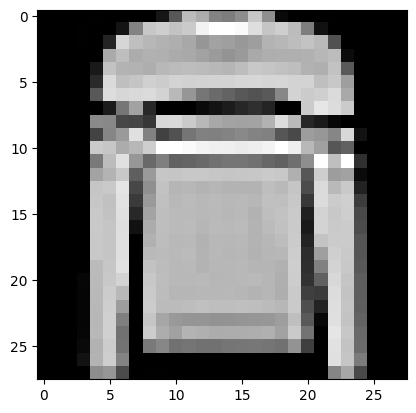

In [10]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_dataset[5]
image = np.array(image).squeeze()
print("Min : ", np.min(image[0]), " /// Max : ", np.max(image[0]))
print("Data type :", image[0].dtype)
# plot the sample

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

# Actual QNN

> QNN = Quantized Neural Network

That's what we are about to do using Quantized Aware Training, and the best part is Brevitas handles all of it in the background !

This part is about creating a quantized version of the model and adapting it to finn.

In [11]:
import torch
from brevitas.nn import QuantLinear
from brevitas.nn import QuantReLU

import torch.nn as nn

brevitas_input_size = 28 * 28
brevitas_hidden1 = 64
brevitas_hidden2 = 64
brevitas_num_classes = 10
weight_bit_width = 4
act_bit_width = 4
dropout_prob = 0.5

#is this model fully quantized or only the wieghts, i shall dig to find out once done !
brevitas_model = nn.Sequential(
    QuantLinear(brevitas_input_size, brevitas_hidden1, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(brevitas_hidden1),
    nn.Dropout(0.5),
    QuantReLU(bit_width=act_bit_width),
    QuantLinear(brevitas_hidden1, brevitas_hidden2, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(brevitas_hidden2),
    nn.Dropout(0.5),
    QuantReLU(bit_width=act_bit_width),
    QuantLinear(brevitas_hidden2, brevitas_num_classes, bias=True, weight_bit_width=weight_bit_width),
    QuantReLU(bit_width=act_bit_width)
)

# uncomment to check the network object
# brevitas_model

### The input data has to be quantized.

Normaly in brevistas, we can use the ```QuantIdentity()``` layer for this but unfortunatly, it does not convert to hardware (yet) in FINN.

It its really not a problem, as we can just quantize the input data !

In [12]:
from torch.utils.data import Dataset

# Define a custom quantization function
def quantize_tensor(x, num_bits=8):
    qmin = 0.
    qmax = 2.**num_bits - 1.
    min_val, max_val = x.min(), x.max()

    scale = (max_val - min_val) / (qmax - qmin)
    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    
    return q_x

# Define the quantized transform
transform_quantized = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Lambda(lambda x: quantize_tensor(x))  # Apply quantization
])

# Load the training dataset
train_dataset_qnt = datasets.FashionMNIST(
    root='./data',  # Directory to save the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_quantized  # Apply the defined transformations
);

# Load the test dataset
test_dataset_qnt = datasets.FashionMNIST(
    root='./data',
    train=False,  # Load the test set
    download=True,
    transform=transform_quantized
)

train_loader = DataLoader(train_dataset_qnt, 100)
test_loader = DataLoader(test_dataset_qnt, 100)

Let's re-visualize the data now... That's better !!

Min :  0.0  /// Max :  255.0
float32


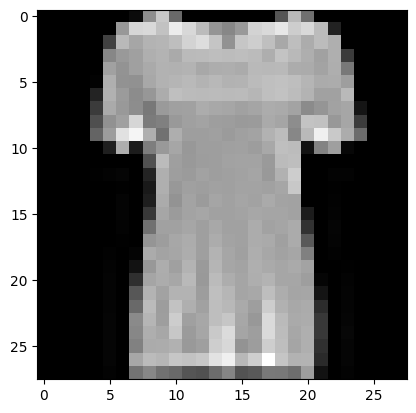

In [13]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_dataset_qnt[10]
image = np.array(image).squeeze()
print("Min : ", np.min(image), " /// Max : ", np.max(image))
print(image.dtype)

# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

## Actual training

Now, just like in a regular PyTorch workflow, we train the model using a simple trainng loop.

Note that it takes a bit of time because
- We train on CPU
- QAT "simulates" Quantization using quant/dequant layers (so the model becomes robust to quantization, which is not the case in PTQ) and backpropagation is different and that takes up computing power

In [14]:
# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(brevitas_model.parameters(), lr=0.001, betas=(0.9, 0.999))

num_epochs = 5
brevitas_model.train()
batch_size = 100

for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = torch.reshape(images, (batch_size, 28*28))
        out = brevitas_model(images.float()) # This just make the value a float ie 255 becomes 255,0 and not 1
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.7165
Epoch [2/5], Loss: 0.6275
Epoch [3/5], Loss: 0.6060
Epoch [4/5], Loss: 0.5052
Epoch [5/5], Loss: 0.4777


We now test the model with ~85% accuracy, which is extremely close to non-quatized model performances (~85-86% when I tested it on my side when I made the course).

This dataset isn't very complex though, this delta will depend on the data you have to classify.

In [15]:
# test the model

brevitas_model.eval()
correct = 0
total = 0
loss_total = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = torch.reshape(images, (batch_size, 28*28))
        out = brevitas_model(images.float())
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print("accuracy =", accuracy, "%")

accuracy = 84.49 %


Here are some lines to execute the tensor that mmakes up the model and their different representations :

In [16]:
#lets have a quick look at the weights too
print(brevitas_model[0].quant_weight())
#internally, weoght are stored as float 32, here nare ways to visualize actual quantized weights :
print(brevitas_model[0].quant_weight().int())
print(brevitas_model[0].quant_weight().int().dtype)

QuantTensor(value=tensor([[ 0.0296,  0.0000, -0.0296,  ...,  0.0000,  0.0296, -0.0888],
        [ 0.0296,  0.0592,  0.0000,  ...,  0.0888,  0.0000,  0.0296],
        [-0.0000,  0.0296, -0.0296,  ...,  0.0296,  0.0888,  0.0592],
        ...,
        [ 0.0000, -0.0592, -0.0592,  ...,  0.0888,  0.0888, -0.0000],
        [ 0.0296,  0.0000,  0.0888,  ...,  0.0592,  0.1184,  0.1480],
        [-0.0888, -0.0000, -0.0296,  ...,  0.0592,  0.0296, -0.0296]],
       grad_fn=<MulBackward0>), scale=tensor(0.0296, grad_fn=<DivBackward0>), zero_point=tensor(0.), bit_width=tensor(4.), signed_t=tensor(True), training_t=tensor(False))
tensor([[ 1,  0, -1,  ...,  0,  1, -3],
        [ 1,  2,  0,  ...,  3,  0,  1],
        [ 0,  1, -1,  ...,  1,  3,  2],
        ...,
        [ 0, -2, -2,  ...,  3,  3,  0],
        [ 1,  0,  3,  ...,  2,  4,  5],
        [-3,  0, -1,  ...,  2,  1, -1]], dtype=torch.int8)
torch.int8


# EXPORTING THE MODEL TO FINN-ONNX

maybe you know ONNX, maybe you don't. At the end of the day, It's just a way to represent AI models (or just tensor operations) in an optimised an standard way. It also allows us to use Netron to visualize the model as a nice graph.

> FINN-ONNX is just like ONNX, exept it's better for quantized models (under 8bit quantization).

In [17]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

filename = root_dir + "/part1.onnx"
filename_clean = root_dir + "/part1_clean.onnx"

def asymmetric_quantize(arr, num_bits=8):
    min = 0
    max = 2**num_bits - 1
    
    beta = np.min(arr)
    alpha = np.max(arr)
    scale = (alpha - beta) / max
    zero_point = np.clip((-beta/scale),0,max).round().astype(np.int8)

    quantized_arr = np.clip(np.round(arr / scale + zero_point), min, max).astype(np.float32)
    
    return quantized_arr

#Crete a tensor ressembling the input tensor we saw earlier
input_a = np.random.rand(1,28*28).astype(np.float32)
input_a = asymmetric_quantize(input_a)
print(np.max(input_a[0]))
scale = 1.0
input_t = torch.from_numpy(input_a * scale)

# Export to ONNX
export_qonnx(
    brevitas_model, export_path=filename, input_t=input_t
)

# clean-up
qonnx_cleanup(filename, out_file=filename_clean)

# ModelWrapper
model = ModelWrapper(filename_clean)
model = model.transform(ConvertQONNXtoFINN())
model.save(root_dir + "/ready_finn.onnx")

print("Model saved to " + root_dir + "/ready_finn.onnx")

255.0
Model saved to /tmp/finn_dev_emre/ready_finn.onnx


/home/emre/Documents/finn/deps/qonnx/src/qonnx/transformation/gemm_to_matmul.py:57: UserWarning: The GemmToMatMul transformation only offers explicit support for version 9 of the Gemm node, but the ONNX version of the supplied model is 14. Thus the transformation may fail or return incomplete results.
  warnings.warn(


## Visualization in Netron

We can now visualise our network in netron, we can clearly identify each layer in this graph, Great !

In [18]:
from finn.util.visualization import showInNetron

showInNetron(root_dir + "/ready_finn.onnx")

Serving '/tmp/finn_dev_emre/ready_finn.onnx' at http://0.0.0.0:8081


We are now ready to move on to FINN !

# From trained model to HW using the finn compiler

We will go through network preparation (mainly through [Strealining](https://arxiv.org/pdf/1709.04060) graph transformations) and conversion to HW using the finn compiler.

In [19]:
user_name = "emre" # REPLACE THIS WITH YOUR HOST MACHINE USER NAME 
root_dir = f"/tmp/finn_dev_{user_name}"
print(root_dir)
# get onnx model from the last NOTEBOOK
filename = root_dir + "/ready_finn.onnx"

/tmp/finn_dev_emre


In [20]:
from finn.util.visualization import showSrc, showInNetron
showInNetron(filename)

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emre/ready_finn.onnx' at http://0.0.0.0:8081


# Network preparing for finn

## Steps summary

- Tidy up (and also after EACH step)
- Pre (data feed) / Post proc (top k)
- **Model streamlining (Main step)** + smaller example
- Model HW Layers (Generates Matrix Vector Activation Units for fc layers)
- Model data flow partitions (Generate a sub-graph for all HW convertible nodes)
- Specialize layer, ready for hw conversion (generates hls for the dataflow partition node)

We then adapt the compiler setting depending on the ressources requirements and call FINN API to generate a stitched IP.

## Tidy up

The goal of these transformation are simply to give node names & identifiers.

In [21]:
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.core.modelwrapper import ModelWrapper

model = ModelWrapper(filename)

# TIDY UP
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())

model.save(root_dir + "/tidy.onnx")

showSrc(InferShapes)

class InferShapes(Transformation):
    """Ensure every tensor in the model has a specified shape (ValueInfo)."""

    def apply(self, model):
        # hide your riches!
        hidden_ops = _hide_finn_ops(model)
        # call regular ONNX shape inference
        model = ModelWrapper(si.infer_shapes(model.model))
        # bring back hidden ops
        _restore_finn_ops(model, hidden_ops)
        return (model, False)



In [22]:
showInNetron(root_dir + "/tidy.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emre/tidy.onnx' at http://0.0.0.0:8081


## Pre processing

FINN model will only use 0 to 255 INT8 input once in hgardware, [or at least it will assume integer input](https://github.com/Xilinx/finn/issues/1174#issuecomment-2331778330)

We will feed UINT8 quantized values into the model, ranging from 0 to 255, because we did so in training. If the model was trained on FP32 ranging from 0 to 1, adding preprocessing into the graph, like in the commented example below, would be the right solution.

We also grab the opportunity to infer the input data type for the FINN compiler to adapt the input interface processing.

In [23]:
from finn.util.pytorch import ToTensor
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.datatype import DataType
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
import torch
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

# PRE PROC : NONE
model = ModelWrapper(root_dir + "/tidy.onnx")

#=========================================================
# Here you could add some proprocessing if you need some
#=========================================================

# add input annotation: UINT8 is what we will feed the model during inference
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])


model.save(root_dir + "/full_preproc.onnx")
showInNetron(root_dir + "/full_preproc.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emre/full_preproc.onnx' at http://0.0.0.0:8081


## OPTIONAL : VERIFICATION : TEST THE "NEW" MODEL and VERIFY IT

Now, we can test this new model in order to check wether we did a good job so far with the different datatypes.

To test our new model, we will use the ONNX runtime that allows us to directly run an ONNX model a gather output.

> Note that the FINN-ONNX runtime is not very performant but its okay for our purpose

Normally, this ONNX runtime is used **EXTENSILVLY** to **VERIFY** everything we do **EVERYTIME WE CHANGE THE MODEL**. In this tutorial, i'll just give you this example so you kno how to use it but given the simplicity of the model, I will only give you this example.

### Some examples for confimed users :

> Finish this notebook first to fully undertand the following statements :

You can see more uses cases of the ONNX Runtime used for verification [here](https://github.com/Xilinx/finn/blob/main/notebooks/end2end_example/bnn-pynq/tfc_end2end_verification.ipynb). In this notebook from FINN, they use the ONNX runtime to verfy C++ and RTL functionality of the code generated in the later portions WITHOUT EVER DESIGNING A TESBENCH !!! this is very powerful !

[Here](https://github.com/0BAB1/python_to_fpga_course/blob/main/Lab%202%20%3A%20FINN%20Compiler/LAB2_VERIFICATION.ipynb) is a link to the verification notebook from my full 9h course, the notebook may not be as complete but the code is functional on this model. A good exercice for you would be to try and verify these models if you want to ! anyway, it is not andatory for hobby projects.

In [24]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from qonnx.core.modelwrapper import ModelWrapper
import qonnx.core.onnx_exec as oxe

model = ModelWrapper(root_dir + "/full_preproc.onnx")

#=========================================================
# FIRST WE GATHER AND QUANTIZE SOME DATA TO TEST
#=========================================================

# get some INT 8 data by quantizing some FashionMNIST data
def quantize_tensor(x, num_bits=8):
    qmin = 0.
    qmax = 2.**num_bits - 1.
    min_val, max_val = x.min(), x.max()

    scale = (max_val - min_val) / (qmax - qmin)
    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    
    return q_x

# Define the quantized transform
transform_quantized = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Lambda(lambda x: quantize_tensor(x))  # Apply quantization
])

# Load the test dataset
test_dataset_qnt = datasets.FashionMNIST(
    root='./data',
    train=False,  # Load the test set
    download=True,
    transform=transform_quantized
);

test_loader_qnt = DataLoader(test_dataset_qnt, 100)

#=========================================================
# RUN THE TESTING LOOP
#=========================================================

correct = 0
total = 0
loss_total = 0
print("\\nRunning the testing loop with ONNX model inference !\n")

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader_qnt):
        images = torch.reshape(images, (100, 28*28))
        for image_idx, image in enumerate(images):
            input_tensor = image.detach().numpy().reshape(1, 28 * 28)
            # print(input_tensor)
            input_dict = {"global_in": input_tensor}
            output_dict = oxe.execute_onnx(model, input_dict)
            produced_qonnx = output_dict[list(output_dict.keys())[0]]
            _, predicted = torch.max(torch.from_numpy(produced_qonnx).data, 1)
            total += 1
            correct += predicted.item() == labels[image_idx].item()
            if image_idx % 10 == 0 :
                print(image_idx, "done ! Accuracy so far : ", 100 * correct / total)
        if batch_idx == 0 : break # just do 1 batch, too long !

    accuracy = 100 * correct / total
    print("accuracy =", accuracy, "%")

\nRunning the testing loop with ONNX model inference !

0 done ! Accuracy so far :  100.0
10 done ! Accuracy so far :  100.0
20 done ! Accuracy so far :  90.47619047619048
30 done ! Accuracy so far :  83.87096774193549
40 done ! Accuracy so far :  85.36585365853658
50 done ! Accuracy so far :  82.3529411764706
60 done ! Accuracy so far :  83.60655737704919
70 done ! Accuracy so far :  81.69014084507042
80 done ! Accuracy so far :  83.95061728395062
90 done ! Accuracy so far :  84.61538461538461
accuracy = 86.0 %


## POST PROCESSING

We also apply post processing ! In our case we add a "tok K" label selector that will directly output the class value with the most credence. We grab the opportunity to do a tidy up again, as we added nodes in the graph that were not there in the fity tidy up graph transformations.

After that, we visualize in Netron (as usual, you know the drill now). And we can now see the label selector (topK) at the end of the model and the output shape is now 1x1 aka, a simple scalar designating the class ID.

In [25]:
from qonnx.transformation.insert_topk import InsertTopK

# POST PROC

# insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = root_dir + "/pre_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

showInNetron(chkpt_name)

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emre/pre_post.onnx' at http://0.0.0.0:8081


## Model [streamlining](https://arxiv.org/pdf/1709.04060)

This set of transformations are one of the main steps, it infer thesholds in the graph and moves operations around. The end goal is to have a full integers model for inference and a streamlined graph structure easily convertible in HW layers.

You can vizualize the set of transformation in [this paper](https://arxiv.org/pdf/1709.04060) or by using ```showSrc(Streamline)```

> At the end, you can see in the graph, if you open weights details, that we only have INT remaining, with the exception of a single scalar slace factor at the end, that will later get absorbed in the top K using a special transform in the next cell.

In [26]:
from finn.transformation.streamline import Streamline
# we can see the list of apllied transformations here : showSrc(Streamline)
from finn.transformation.streamline.reorder import MoveScalarLinearPastInvariants
import finn.transformation.streamline.absorb as absorb

model = ModelWrapper(root_dir + "/pre_post.onnx")
# STREAMLINE
model = model.transform(Streamline())
model.save(root_dir + "/streamlined.onnx")
showInNetron(root_dir + "/streamlined.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emre/streamlined.onnx' at http://0.0.0.0:8081


As we said, there still is this scalar MUL haging around in our network...

> Is tha bad ?

YES ! it's a floating point scale ! we need to get rid of it !

Depending on your architecture, only running the streline transform might not be enough. In that case, you can simply look into the [availible stremline transformations](https://finn.readthedocs.io/en/latest/source_code/finn.transformation.streamline.html) and pick the one that is the most suitable to fully end you model preparation/streamlining process.

> Note : depending on your architecture, you might be in a scenario where **NO MODEL TRANSFORMATION IS ENOUGH**. This can happen, you can open an issue in the [FINN GitHub](https://github.com/Xilinx/finn/tree/main/notebooks) and see from there what course of action to take. If really needed, you can operate some operation in sofware using a CPU alongside you FPGA.

In [27]:
from finn.transformation.streamline.round_thresholds import RoundAndClipThresholds
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.general import RemoveUnusedTensors
import finn.transformation.streamline.absorb as absorb

model = ModelWrapper(root_dir + "/streamlined.onnx")

# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(RoundAndClipThresholds())

# bit of tidy-up
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())

model.save(root_dir + "/streamlined_merged_and_ready.onnx")
showInNetron(root_dir + "/streamlined_merged_and_ready.onnx")

Stopping http://0.0.0.0:8081


/home/emre/Documents/finn/deps/qonnx/src/qonnx/transformation/infer_data_layouts.py:136: UserWarning: Assuming 2D input is NC
  warnings.warn("Assuming 2D input is NC")


Serving '/tmp/finn_dev_emre/streamlined_merged_and_ready.onnx' at http://0.0.0.0:8081


# Convert to HW

## Generate HW Layers : MVAU

This step does not generate HLS nor RTL code, but rather merges thresholds and matrix vector operations (or convolutions if you use conv nets) into Matrix Vector Activation Units (or Sliding Window Units), if possible,  that each represent a layer that FINN can easily work with. Note that an input preprocessing quantiazer will be implemented as a simple standalone Threasholding layer that will then nbe converted to Thresholding_hls layer.

See the [FINN PAPER](https://arxiv.org/pdf/1612.07119) Section 4 (page 4 to 6+ especially) for more details.

In [28]:
import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw
from qonnx.core.modelwrapper import ModelWrapper

# TO HW LAYERS

model = ModelWrapper(root_dir + "/streamlined_merged_and_ready.onnx")
model = model.transform(to_hw.InferLabelSelectLayer())
model = model.transform(to_hw.InferChannelwiseLinearLayer())
model = model.transform(to_hw.InferQuantizedMatrixVectorActivation())
model = model.transform(to_hw.InferThresholdingLayer())
model.save(root_dir + "/hw.onnx")
showInNetron(root_dir + "/hw.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emre/hw.onnx' at http://0.0.0.0:8081


### Isolate HW convertible layers.

Once MVAU are infered, we can ask FINN to discriminate HW convertible layers into dataflow partitions.

> In this example, everything is convertible to HW, meaning the whole model will be transfered in the "streaming dataflow partition" and that the whole thing will get implemented on FPGA (aka no need to do sofware processing using any kind of CPU) !

In [29]:
from finn.transformation.fpgadataflow.create_dataflow_partition import CreateDataflowPartition

model = ModelWrapper(root_dir + "/hw.onnx")
parent_model = model.transform(CreateDataflowPartition())
parent_model.save(root_dir + "/df_part.onnx")
showInNetron(root_dir + "/df_part.onnx")

# We see that our entire model is now part of a child model in "StreamingDataflowPartition"

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emre/df_part.onnx' at http://0.0.0.0:8081


We select the child streaming dataflow model to work on it (i.e. do the actual HLS/RTL conversion) using [getCustopOp](https://finn.readthedocs.io/en/latest/source_code/finn.custom_op.html)

In [30]:
from qonnx.custom_op.registry import getCustomOp
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
showInNetron(dataflow_model_filename)

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emre/dataflow_partition_ysw42mbv/partition_0.onnx' at http://0.0.0.0:8081


## MVAU HLS Conversion

In this process, we simply runnn a FINN API call that will generate HLS Layers from the MVAU / SLWU. To adapt the resulting HLS code, we also chose an FPGA part from the supported pool. You can simply choose a part that "ressembles" your end target as this is not the end Synth target for Vitis HLS RTL conversion.

In [31]:
# print the names of the supported PYNQ boards
from finn.util.basic import pynq_part_map
print(pynq_part_map.keys())

# change this if you have a different PYNQ board, see list above
pynq_board = "Pynq-Z1"
fpga_part = pynq_part_map[pynq_board]
target_clk_ns = 20

dict_keys(['Ultra96', 'Ultra96-V2', 'Pynq-Z1', 'Pynq-Z2', 'ZCU102', 'ZCU104', 'ZCU111', 'RFSoC2x2', 'RFSoC4x2', 'KV260_SOM'])


In [32]:
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers
model = ModelWrapper(dataflow_model_filename)

model = model.transform(SpecializeLayers(fpga_part))

showSrc(SpecializeLayers)

model.save(root_dir + "/to_hw_conv.onnx")
showInNetron(root_dir + "/to_hw_conv.onnx")

class SpecializeLayers(Transformation):
    """Specialize all layers to either HLS or RTL variants"""

    def __init__(self, fpgapart):
        super().__init__()
        self.fpgapart = fpgapart

    def apply(self, model):
        graph = model.graph
        node_ind = 0
        graph_modified = False
        for node in graph.node:
            # Skip nodes that are not hw layers
            if not node.domain == "finn.custom_op.fpgadataflow":
                continue
            node_ind += 1
            impl_style = _determine_impl_style(node, self.fpgapart, model)
            optype = node.op_type + "_" + impl_style

            new_node = helper.make_node(
                optype,
                node.input,
                node.output,
                domain="finn.custom_op.fpgadataflow." + impl_style,
            )
            # add all attributes
            for attribute in node.attribute:
                if attribute.name != "preferred_impl_style":
                    new_no

## OPTIONAL : FOLDING PARAMETER AND LOOP UNROLLING

> This part is optional but gives you control over the ressource usage. You can skip it if you want.

Folding is another way to describe the **"Loop unrolling"** process, aka, how much computing you want to run in parallel.

It basically is the part where you do tradeoffs between speed and ressource usage.

When dealing with ressource requirements, tinkering these parameters is the ways to go in order to find a balance between throughput and ressource utilization. Here are some examples from the [finn paper, table 3 on page 8](https://arxiv.org/pdf/1612.07119) on BNNs and the effect of maximize and minimizing the usage :

![image.png](attachment:image.png)

### regarding the effects

Some vocabulary first :

- PE = Processing Elements => aka actual computing units that will run [MAC](https://en.wikipedia.org/wiki/Multiply%E2%80%93accumulate_operation) operations.
   - => Theorically improves computing throughput.
- SIMD = [Single Instruction Multiple Data](https://fr.wikipedia.org/wiki/Single_instruction_multiple_data) => aka a way to feed MULTIPLE data at ONCE in a signle PE
   - => Theorically improves datapath bandwidth.

> In general, the higher the PE and SIMD values are set, the faster the generated accelerator will run, and the more FPGA resources ([LUTs](https://en.wikipedia.org/wiki/Lookup_table), see the "*Hardware LUTs*" chapter) it will use. 

See [finn paper, figure 5 on page 5](https://arxiv.org/pdf/1612.07119) or refer to the lectures for better understanding of PE, SIMD, LOOP UNROLLING & FOLDING

### Gather information on current params

> Running the following cell of code will you you infos on the current folding parameters

Note that the default "0" value means that you let FINN sort it out for you.

In [33]:
model = ModelWrapper(root_dir + "/to_hw_conv.onnx")

fc0 = model.graph.node[0] #1st MVAU
fc0w = getCustomOp(fc0)

print("CustomOp wrapper is of class " + fc0w.__class__.__name__)

fc0w.get_nodeattr_types()

CustomOp wrapper is of class MVAU_hls


{'PE': ('i', True, 0),
 'SIMD': ('i', True, 0),
 'MW': ('i', True, 0),
 'MH': ('i', True, 0),
 'resType': ('s', False, 'auto', {'auto', 'dsp', 'lut'}),
 'ActVal': ('i', False, 0),
 'inputDataType': ('s', True, ''),
 'weightDataType': ('s', True, ''),
 'outputDataType': ('s', True, ''),
 'accDataType': ('s', False, 'INT32'),
 'binaryXnorMode': ('i', False, 0, {0, 1}),
 'noActivation': ('i', False, 0, {0, 1}),
 'numInputVectors': ('ints', False, [1]),
 'mem_mode': ('s',
  False,
  'internal_decoupled',
  {'external', 'internal_decoupled', 'internal_embedded'}),
 'ram_style': ('s', False, 'auto', {'auto', 'block', 'distributed', 'ultra'}),
 'ram_style_thresholds': ('s',
  False,
  'auto',
  {'auto', 'block', 'distributed'}),
 'runtime_writeable_weights': ('i', False, 0, {0, 1}),
 'backend': ('s', True, 'fpgadataflow'),
 'preferred_impl_style': ('s', False, '', {'', 'hls', 'rtl'}),
 'code_gen_dir_ipgen': ('s', False, ''),
 'ipgen_path': ('s', False, ''),
 'ip_path': ('s', False, ''),
 'ip_

### Set the folding "automatically" using SetFolding

See manual example in this [finn notebook](https://github.com/Xilinx/finn/blob/main/notebooks/end2end_example/bnn-pynq/tfc_end2end_example.ipynb).

SetFolding will automatically try to figure out PE ans SIMD parameter depending on target requirements.

In [34]:
from finn.transformation.fpgadataflow.set_folding import SetFolding

TARGET_FPS = 1000000
target_clk_cycles_per_frame = 1/(TARGET_FPS * 10e-9)

model = ModelWrapper(root_dir + "/to_hw_conv.onnx")
# Actual method SetFolding that will automatically modify the folding settings
model.transform(SetFolding(target_cycles_per_frame=target_clk_cycles_per_frame, mvau_wwidth_max=64, two_pass_relaxation=True))
model.save(root_dir + "/to_hw_folded.onnx")

### For experts :

Note that you can also use [this transformation](https://github.com/Xilinx/finn/blob/9d299689f2ec0895f208b8bfe3bcdcf6f450181a/src/finn/transformation/fpgadataflow/set_fifo_depths.py#L199) to modify the input fifos and output fifos depth of each layer if needed. I never had problems with this so I'll let do your own reasearch if needed.

# ACTUAL HARDWARE BUILD

## First, run an estimate

We first run some estimations based on the TARGET FPS constant defined earlier

In [35]:
# ESTIMATE
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = root_dir + "/to_hw_folded.onnx"

estimates_output_dir = "output_estimates_only"

#Delete previous run results if exist
if os.path.exists(estimates_output_dir):
    shutil.rmtree(estimates_output_dir)
    print("Previous run results deleted!")


cfg_estimates = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = TARGET_FPS,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xc7z020clg400-1",
    steps               = build_cfg.estimate_only_dataflow_steps,
    generate_outputs=[
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
    ]
)

build.build_dataflow_cfg(model_file, cfg_estimates)

Previous run results deleted!
Building dataflow accelerator from /tmp/finn_dev_emre/to_hw_folded.onnx
Intermediate outputs will be generated in /tmp/finn_dev_emre
Final outputs will be generated in output_estimates_only
Build log is at output_estimates_only/build_dataflow.log
Running step: step_qonnx_to_finn [1/10]
Running step: step_tidy_up [2/10]
Running step: step_streamline [3/10]
Running step: step_convert_to_hw [4/10]
Running step: step_create_dataflow_partition [5/10]
Running step: step_specialize_layers [6/10]
Running step: step_target_fps_parallelization [7/10]
Running step: step_apply_folding_config [8/10]
Running step: step_minimize_bit_width [9/10]
Running step: step_generate_estimate_reports [10/10]
Completed successfully


0

### Read the estimates reports

In these reports, we can see the estimates fits our target, and we can get an overview of hw many LUTs will be used

In [36]:
! cat {estimates_output_dir}/report/estimate_network_performance.json

{
  "critical_path_cycles": 252,
  "max_cycles": 98,
  "max_cycles_node_name": "MVAU_hls_0",
  "estimated_throughput_fps": 1020408.1632653062,
  "estimated_latency_ns": 2520.0
}

If you did the folding part, you can check here if your estimated FPS throughput is close to your TARGET_FPS. During my tesing, I had a 1 020 408 FPS estimate for a 1 000 000 Target, which is pretty close.

In [37]:
import json
def read_json_dict(filename):
    with open(filename, "r") as f:
        ret = json.load(f)
    return ret

read_json_dict(estimates_output_dir + "/report/estimate_layer_cycles.json")

{'MVAU_hls_0': 98, 'MVAU_hls_1': 64, 'MVAU_hls_2': 80, 'LabelSelect_hls_0': 10}

In [38]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_resources.json")

{'MVAU_hls_0': {'BRAM_18K': 57,
  'BRAM_efficiency': 0.19103313840155944,
  'LUT': 34338,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_1': {'BRAM_18K': 8,
  'BRAM_efficiency': 0.1111111111111111,
  'LUT': 3133,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_2': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.1388888888888889,
  'LUT': 657,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'LabelSelect_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'total': {'BRAM_18K': 66.0, 'LUT': 38128.0, 'URAM': 0.0, 'DSP': 0.0}}

## Run the actual harware build

> This step can take a lot of time.

> MAke sure you did your dev enrionement setup right, aka all the ENV varibles that should point on the xilinx tools are sourced

In [39]:
# Actual hardware build, ZYNQ BUILD
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild
from finn.transformation.fpgadataflow.replace_verilog_relpaths import ReplaceVerilogRelPaths

model = ModelWrapper(root_dir + "/to_hw_conv.onnx")

model = model.transform(ReplaceVerilogRelPaths())
model = model.transform(ZynqBuild(platform = pynq_board, period_ns = target_clk_ns,partition_model_dir="./test",enable_debug=True))

/home/emre/Documents/finn/src/finn/transformation/fpgadataflow/floorplan.py:107: UserWarning: 6 nodes have no entry in the provided floorplan, SLR was set to -1
  warnings.warn(
/home/emre/Documents/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:234: UserWarning: Input FIFO for IODMA_hls_0_out0 has depth 2 and won't
                        be created. This may cause RTL simulation issues.
                        
  warnings.warn(
/home/emre/Documents/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:294: UserWarning: Output FIFO for LabelSelect_hls_0_out0 has depth 2 and won't
                        be created. This may cause RTL simulation issues.
                        
  warnings.warn(
/home/emre/Documents/finn/src/finn/transformation/fpgadataflow/create_stitched_ip.py:290: UserWarning: First node is not StreamingFIFO or IODMA.
                You may experience incorrect stitched-IP rtlsim or hardware
                behavior. It is strongly recommended to insert

In [40]:
model.save(root_dir + "/post_synth.onnx")

In [41]:
showInNetron(root_dir + "/post_synth.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_emre/post_synth.onnx' at http://0.0.0.0:8081


In [42]:
model = ModelWrapper(root_dir + "/post_synth.onnx")

In [43]:
model.model.metadata_props

[key: "floorplan_json"
value: "/tmp/finn_dev_emre/vitis_floorplan_fuv137o9/floorplan.json"
, key: "vivado_pynq_proj"
value: "/tmp/finn_dev_emre/vivado_zynq_proj_8udz2zj5"
, key: "bitfile"
value: "/tmp/finn_dev_emre/vivado_zynq_proj_8udz2zj5/resizer.bit"
, key: "hw_handoff"
value: "/tmp/finn_dev_emre/vivado_zynq_proj_8udz2zj5/resizer.hwh"
, key: "vivado_synth_rpt"
value: "/tmp/finn_dev_emre/vivado_zynq_proj_8udz2zj5/synth_report.xml"
, key: "platform"
value: "zynq-iodma"
]

## Some output IPs examples :

![image.png](attachment:62288775-2dba-4775-8510-34eb8f89ffe6.png)

![image.png](attachment:2557d696-c367-4597-890c-b340ad8fb3ee.png)  